In [1]:
!git clone https://github.com/oasysokubo/Track.ai.git

Cloning into 'Track.ai'...
remote: Enumerating objects: 13470, done.
remote: Total 13470 (delta 0), reused 0 (delta 0), pack-reused 13470
Receiving objects: 100% (13470/13470), 198.36 MiB | 34.32 MiB/s, done.
Checking out files: 100% (13525/13525), done.


In [2]:
!ls Track.ai

driving_log.csv  IMG


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
import ntpath

In [4]:
datadir = 'Track.ai'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\center_2019_10_17_19_13_59_202.jpg,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\left_2019_10_17_19_13_59_202.jpg,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\right_2019_10_17_19_13_59_202.jpg,0.0,0.0,0.0,0.000082
1,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\center_2019_10_17_19_13_59_314.jpg,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\left_2019_10_17_19_13_59_314.jpg,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\right_2019_10_17_19_13_59_314.jpg,0.0,0.0,0.0,0.000078
2,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\center_2019_10_17_19_13_59_422.jpg,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\left_2019_10_17_19_13_59_422.jpg,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\right_2019_10_17_19_13_59_422.jpg,0.0,0.0,0.0,0.000081
3,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\center_2019_10_17_19_13_59_531.jpg,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\left_2019_10_17_19_13_59_531.jpg,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\right_2019_10_17_19_13_59_531.jpg,0.0,0.0,0.0,0.000080
4,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\center_2019_10_17_19_13_59_635.jpg,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\left_2019_10_17_19_13_59_635.jpg,C:\Users\Oasysokubo\Desktop\Autodrive Data\IMG\right_2019_10_17_19_13_59_635.jpg,0.0,0.0,0.0,0.000079


In [5]:
# Imit the local directory from the name of file

def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_10_17_19_13_59_202.jpg,left_2019_10_17_19_13_59_202.jpg,right_2019_10_17_19_13_59_202.jpg,0.0,0.0,0.0,0.000082
1,center_2019_10_17_19_13_59_314.jpg,left_2019_10_17_19_13_59_314.jpg,right_2019_10_17_19_13_59_314.jpg,0.0,0.0,0.0,0.000078
2,center_2019_10_17_19_13_59_422.jpg,left_2019_10_17_19_13_59_422.jpg,right_2019_10_17_19_13_59_422.jpg,0.0,0.0,0.0,0.000081
3,center_2019_10_17_19_13_59_531.jpg,left_2019_10_17_19_13_59_531.jpg,right_2019_10_17_19_13_59_531.jpg,0.0,0.0,0.0,0.000080
4,center_2019_10_17_19_13_59_635.jpg,left_2019_10_17_19_13_59_635.jpg,right_2019_10_17_19_13_59_635.jpg,0.0,0.0,0.0,0.000079


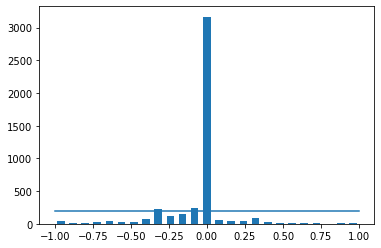

In [6]:
# Plot steering wheels to visualize distribution, see which way is more frequent 

num_bins = 25 # Odd number to attain center of distribution
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 4508
removed: 3033
remaining 1475


"\nThe output is a distribution of steering angles that are much more uniform, viewed data in relative proportion\nThere are significant left and right steering angles, eliminating the extreme bias to driving straight all the time\nThis extreme bias resulted from the training as we drove the car as smooth as possible in the middle of the road, and thereby, recording the \nideal steering angle at all times\n\nWe fix this by cropping most of the extraneous training data\n\nAlternate Solution:\nLet the car continuously steer in either direction drifting to the edge of the road, but not actually hitting the edges\nand have it recover back to the middle before it crashes\nBecause simply driving down the middle of the road and recording that, is not enough to train model to drive properly\n\nImagine the car wanders off to the side of the road in such a case it wouldn't be able to recover back\nto the middle as it wouldn't be able to predict the appropriate left steering measurements therefor

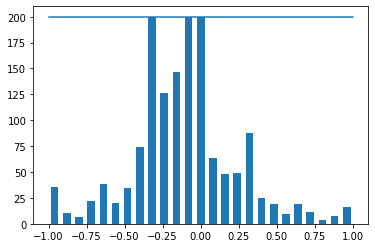

In [7]:
# Flatten data distribution of above data to prevent bias towards centerization
# Uniform our data
# Specify the samples we want to remove
print('total data:', len(data))

remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    # If steering angle falls between two bins, then it belongs to the current interval bin j thats being iterated through
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i) # Point to the steering angle i
  list_ = shuffle(list_) # 
  list_ = list_[samples_per_bin:] # Isolate the indices that go beyond the threshold
  remove_list.extend(list_)
  
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace = True)
print('remaining', len(data))

# Now we have data which cuts of extraneous samples for specific bins whose frequency exceeds 200
# making our data more uniform and less bias

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

"""
The output is a distribution of steering angles that are much more uniform, viewed data in relative proportion
There are significant left and right steering angles, eliminating the extreme bias to driving straight all the time
This extreme bias resulted from the training as we drove the car as smooth as possible in the middle of the road, and thereby, recording the 
ideal steering angle at all times

We fix this by cropping most of the extraneous training data

Alternate Solution:
Let the car continuously steer in either direction drifting to the edge of the road, but not actually hitting the edges
and have it recover back to the middle before it crashes
Because simply driving down the middle of the road and recording that, is not enough to train model to drive properly

Imagine the car wanders off to the side of the road in such a case it wouldn't be able to recover back
to the middle as it wouldn't be able to predict the appropriate left steering measurements therefore
an alternative to manipulating the data in this way is to record a recovery laps where we actually make
a separate recording of the car constantly steering back from the sides.

So what you would do is turn off the recording of the car or wandering off to the side since that's
not the behavior that we want to train the model on but only record once we're going to steer back to
the middle.

And now since having gotten rid of the zero angle bias not completely since we still want our car
to favor driving down the middle let's load our image and steering data into arrays so we're able to
manipulate them and split them into training and validation data.

"""

In [8]:
# Load images as training data and their corresponding steering angles as labels
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)): # Iterate through all available instances
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip())) # Append the main path, allows access and reference all images that were cloned from the repository
    steering.append(float(indexed_data[3]))
  image_path = np.asarray(image_path)
  steering = np.asarray(steering)
  return image_path, steering

image_path, steering = load_img_steering(datadir + '/IMG', data)
print(image_path)

center      center_2019_10_17_19_14_02_829.jpg
left        left_2019_10_17_19_14_02_829.jpg  
right       right_2019_10_17_19_14_02_829.jpg 
steering   -0.28817                           
throttle    0.923624                          
reverse     0                                 
speed       1.98676                           
Name: 31, dtype: object
['Track.ai/IMG/center_2019_10_17_19_14_01_427.jpg'
 'Track.ai/IMG/center_2019_10_17_19_14_02_829.jpg'
 'Track.ai/IMG/center_2019_10_17_19_14_03_398.jpg' ...
 'Track.ai/IMG/center_2019_10_17_19_21_57_877.jpg'
 'Track.ai/IMG/center_2019_10_17_19_21_59_495.jpg'
 'Track.ai/IMG/center_2019_10_17_19_22_00_584.jpg']


In [9]:
# Define training and testing data
X_train, X_valid, y_train, y_valid = train_test_split(image_path, steering, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1180
Valid Samples: 295


Text(0.5, 1.0, 'Validation set')

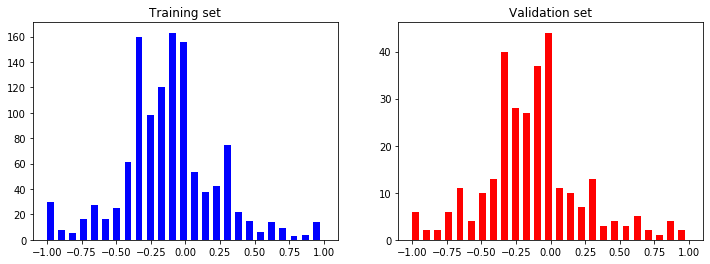

In [10]:
# Validate the quality of our datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [0]:
# Define a preprocessing function
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135, :, :] # Crop image to remove uneccessary noise and background 
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) # Convert image from RGB to YUV color-space
  img = cv2.GaussianBlur(img, (3, 3), 0) # (image, size of gaussian kernel, deviation of kernel)
  img = cv2.resize(img, (200, 66)) # Keep consistence with all images
  img = img/255 # normalization of image
  return img

Text(0.5, 1, 'Preprocessed Image')

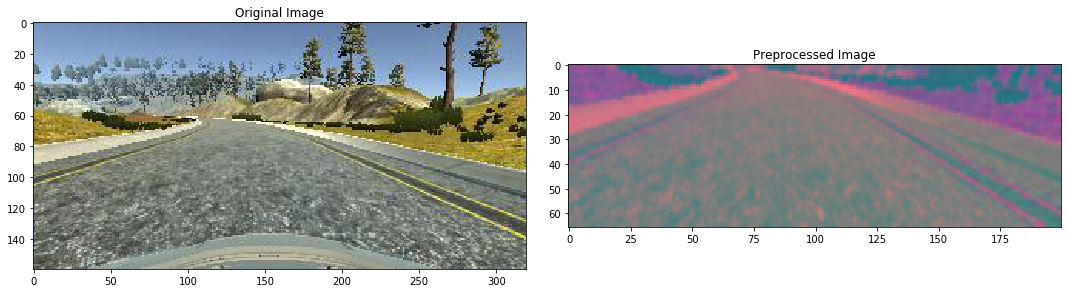

In [12]:
image = image_path[40]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axes = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [0]:
# Preprocess our training/validation sets
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(1180, 66, 200, 3)


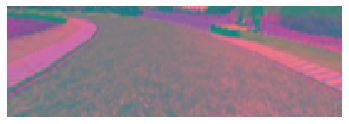

In [14]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)

  return model

In [24]:
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1152)             

In [25]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

Train on 1180 samples, validate on 295 samples
Epoch 1/30
1180/1180 [==============================] - 10s 9ms/step - loss: 1.3146 - val_loss: 0.1561
Epoch 2/30
1180/1180 [==============================] - 10s 8ms/step - loss: 0.2519 - val_loss: 0.1230
Epoch 3/30
1180/1180 [==============================] - 10s 8ms/step - loss: 0.1833 - val_loss: 0.1252
Epoch 4/30
1180/1180 [==============================] - 9s 8ms/step - loss: 0.1520 - val_loss: 0.1244
Epoch 5/30
1180/1180 [==============================] - 10s 8ms/step - loss: 0.1524 - val_loss: 0.1258
Epoch 6/30
1180/1180 [==============================] - 9s 8ms/step - loss: 0.1549 - val_loss: 0.1241
Epoch 7/30
1180/1180 [==============================] - 9s 8ms/step - loss: 0.1413 - val_loss: 0.1239
Epoch 8/30
1180/1180 [==============================] - 10s 8ms/step - loss: 0.1394 - val_loss: 0.1229
Epoch 9/30
1180/1180 [==============================] - 9s 8ms/step - loss: 0.1309 - val_loss: 0.1238
Epoch 10/30
1180/1180 [=======

Text(0.5, 0, 'Epoch')

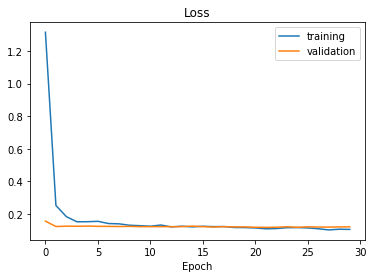

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')